In [5]:
number_of_days = 2
intervalAmt = 15

In [6]:
!pip install numpy pandas seaborn ipywidgets matplotlib plotly mplfinance marimo
#run this if you dont have these things installed in the list below
#this also needs to run in kernal python 3.13.0

In [7]:
import sys
print(sys.executable)

c:\Users\anton\AppData\Local\Programs\Python\Python313\python.exe


In [8]:
!pip list

Package                   Version
------------------------- --------------
anyio                     4.8.0
argon2-cffi               23.1.0
argon2-cffi-bindings      21.2.0
arrow                     1.3.0
asttokens                 3.0.0
async-lru                 2.0.4
attrs                     25.1.0
babel                     2.17.0
beautifulsoup4            4.13.3
bleach                    6.2.0
certifi                   2024.8.30
cffi                      1.17.1
charset-normalizer        3.4.0
click                     8.1.8
colorama                  0.4.6
comm                      0.2.2
contourpy                 1.3.1
cycler                    0.12.1
debugpy                   1.8.13
decorator                 5.2.1
defusedxml                0.7.1
docutils                  0.21.2
executing                 2.2.0
fastjsonschema            2.21.1
filelock                  3.17.0
fonttools                 4.56.0
fqdn                      1.5.1
frozendict                2.4.6
fsspec       

In [9]:
import numpy as np  # Importing numpy for numerical operations
import pandas as pd
import seaborn as sns
from plotly.subplots import make_subplots
from ipywidgets import widgets
from IPython.display import display
from Gen_SPY_With_Indicators import simulate_stock  # Importing simulation function
import matplotlib.pyplot as plt  # Importing matplotlib for plotting
import matplotlib.ticker as mticker  # For proper Y-axis formatting

def generate_signals(df, stop_loss_pct=0.02):
    """ Generates trade signals based on ORB, VWAP, 8EMA, PM High/Low, and Yest High/Low """

    df['Signal'] = ''
    df['Stop_Loss'] = np.nan  # Initialize Stop_Loss column

    # Buy Call: Price breaks ORB High & supported by 8EMA & VWAP
    df.loc[
        (df['Close'] > df['ORB_High']) & 
        (df['Close'] > df['VWAP']) & 
        (df['Close'] > df['8EMA']),
        'Signal'
    ] = 'BUY CALL'

    # Sell Put: Price breaks ORB Low & rejected by 8EMA & VWAP
    df.loc[
        (df['Close'] < df['ORB_Low']) & 
        (df['Close'] < df['VWAP']) & 
        (df['Close'] < df['8EMA']),
        'Signal'
    ] = 'BUY PUT'

    # Boost Call Confidence if PM High or Yesterday's High is broken
    df.loc[
        (df['Signal'] == 'BUY CALL') & 
        ((df['Close'] > df['PM_High']) | (df['Close'] > df['Yest_High'])),
        'Signal'
    ] = 'STRONG BUY CALL'

    # Boost Put Confidence if PM Low or Yesterday's Low is broken
    df.loc[
        (df['Signal'] == 'BUY PUT') & 
        ((df['Close'] < df['PM_Low']) | (df['Close'] < df['Yest_Low'])),
        'Signal'
    ] = 'STRONG BUY PUT'

    # Add stop loss levels
    df.loc[df['Signal'].isin(['BUY CALL', 'STRONG BUY CALL']), 'Stop_Loss'] = df['Close'] * (1 - stop_loss_pct)
    df.loc[df['Signal'].isin(['BUY PUT', 'STRONG BUY PUT']), 'Stop_Loss'] = df['Close'] * (1 + stop_loss_pct)

    return df

# Simulate Stock Data for 2 Days
simulated_data, yesterday_high, yesterday_low = simulate_stock(number_of_days)

# Apply Signal Generation
simulated_data = generate_signals(simulated_data)

import plotly.express as px
import plotly.graph_objects as go

# Set seaborn style
sns.set(style="whitegrid")

# Create a subplot
fig = make_subplots(rows=1, cols=1)

# Function to update the plot based on the toggle button
def update_plot(change):
    fig.data = []  # Clear existing traces

    if toggle_button.value:
        # Add candlestick traces for each day
        for day in simulated_data["Day"].unique():
            day_data = simulated_data[simulated_data["Day"] == day]
            pm_data = day_data[day_data["Session"] == "PM"]
            market_data = day_data[day_data["Session"] == "Regular Market"]

            if not pm_data.empty:
                fig.add_trace(go.Candlestick(x=pm_data['Timestamp'], open=pm_data['Open'], high=pm_data['High'], low=pm_data['Low'], close=pm_data['Close'], name=f"PM Day {day}"))
            if not market_data.empty:
                fig.add_trace(go.Candlestick(x=market_data['Timestamp'], open=market_data['Open'], high=market_data['High'], low=market_data['Low'], close=market_data['Close'], name=f"Regular Market Day {day}"))
    else:
        # Add line traces for each day
        for day in simulated_data["Day"].unique():
            day_data = simulated_data[simulated_data["Day"] == day]
            pm_data = day_data[day_data["Session"] == "PM"]
            market_data = day_data[day_data["Session"] == "Regular Market"]

            fig.add_trace(go.Scatter(x=pm_data['Timestamp'], y=pm_data['Close'], mode='lines', name=f"PM Day {day}", line=dict(color="black", dash="dot"), opacity=0.7))
            fig.add_trace(go.Scatter(x=market_data['Timestamp'], y=market_data['Close'], mode='lines', name=f"Regular Market Day {day}", line=dict(color="steelblue"), opacity=0.8))

    # Add traces for indicators
    fig.add_trace(go.Scatter(x=simulated_data['Timestamp'], y=simulated_data['8EMA'], mode='lines', name="8EMA", line=dict(color="orange")))
    fig.add_trace(go.Scatter(x=simulated_data['Timestamp'], y=simulated_data['VWAP'], mode='lines', name="VWAP", line=dict(color="blue")))

    # Add traces for ORB and PM High/Low
    for day in simulated_data['Day'].unique():
        day_data = simulated_data[simulated_data['Day'] == day]
        fig.add_trace(go.Scatter(x=day_data['Timestamp'], y=day_data['ORB_High'], mode='lines', name="ORB High" if day == 1 else "", line=dict(color="green", dash="dash")))
        fig.add_trace(go.Scatter(x=day_data['Timestamp'], y=day_data['ORB_Low'], mode='lines', name="ORB Low" if day == 1 else "", line=dict(color="red", dash="dash")))
        fig.add_trace(go.Scatter(x=day_data['Timestamp'], y=day_data['PM_High'], mode='lines', name="PM High" if day == 1 else "", line=dict(color="green", dash="dot")))
        fig.add_trace(go.Scatter(x=day_data['Timestamp'], y=day_data['PM_Low'], mode='lines', name="PM Low" if day == 1 else "", line=dict(color="red", dash="dot")))

        market_open_time = day_data['Timestamp'].iloc[0]
        market_close_time = day_data['Timestamp'].iloc[-1]
        if day == 1:
            fig.add_trace(go.Scatter(x=[market_open_time, market_close_time], y=[yesterday_high, yesterday_high], mode='lines', name="Yesterday's High", line=dict(color="gray", dash="dashdot"), opacity=0.7))
            fig.add_trace(go.Scatter(x=[market_open_time, market_close_time], y=[yesterday_low, yesterday_low], mode='lines', name="Yesterday's Low", line=dict(color="brown", dash="dashdot"), opacity=0.7))
        else:
            fig.add_trace(go.Scatter(x=[market_open_time, market_close_time], y=[day_data['Yest_High'].iloc[0], day_data['Yest_High'].iloc[0]], mode='lines', name="Yesterday's High" if day == 2 else "", line=dict(color="gray", dash="dashdot"), opacity=0.7))
            fig.add_trace(go.Scatter(x=[market_open_time, market_close_time], y=[day_data['Yest_Low'].iloc[0], day_data['Yest_Low'].iloc[0]], mode='lines', name="Yesterday's Low" if day == 2 else "", line=dict(color="brown", dash="dashdot"), opacity=0.7))

    # Update layout for better appearance
    fig.update_layout(
        title="Simulated Stock Price with PM, 8EMA, VWAP, ORB, & Yesterday's High/Low",
        xaxis_title="Time",
        yaxis_title="Stock Price",
        legend_title="Legend",
        xaxis=dict(tickangle=45),
        template="seaborn"
    )

    # Show the plot
    fig.show()

# Create a toggle button
toggle_button = widgets.ToggleButton(
    value=False,
    description='Toggle Candlestick',
    disabled=False,
    button_style='',
    tooltip='Toggle between line and candlestick chart',
    icon='line-chart'
)

# Attach the update function to the toggle button
toggle_button.observe(update_plot, names='value')

# Display the toggle button
# display(toggle_button)

# Initial plot update
update_plot(None)

# Print any part of the simulated data that contains BUY CALL or BUY PUT signals during Regular Market session
#print(simulated_data[(simulated_data['Signal'].isin(['BUY CALL', 'BUY PUT', 'STRONG BUY CALL', 'STRONG BUY PUT'])) & (simulated_data['Session'] == 'Regular Market')])

c:\Users\anton\OneDrive\Documents\GitHub\Financial-Engineering-Project\Gen_SPY_With_Indicators.py:108: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  day_df[['ORB_High', 'ORB_Low']] = day_df[['ORB_High', 'ORB_Low']].fillna(method='ffill')
c:\Users\anton\OneDrive\Documents\GitHub\Financial-Engineering-Project\Gen_SPY_With_Indicators.py:115: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  day_df[['PM_High', 'PM_Low']] = day_df[['PM_High', 'PM_Low']].fillna(method='ffill')
c:\Users\anton\OneDrive\Documents\GitHub\Financial-Engineering-Project\Gen_SPY_With_Indicators.py:108: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  day_df[['ORB_High', 'ORB_Low']] = day_df[['ORB_High', 'ORB_Low']].fillna(method='ffill')
c:\Users\anton

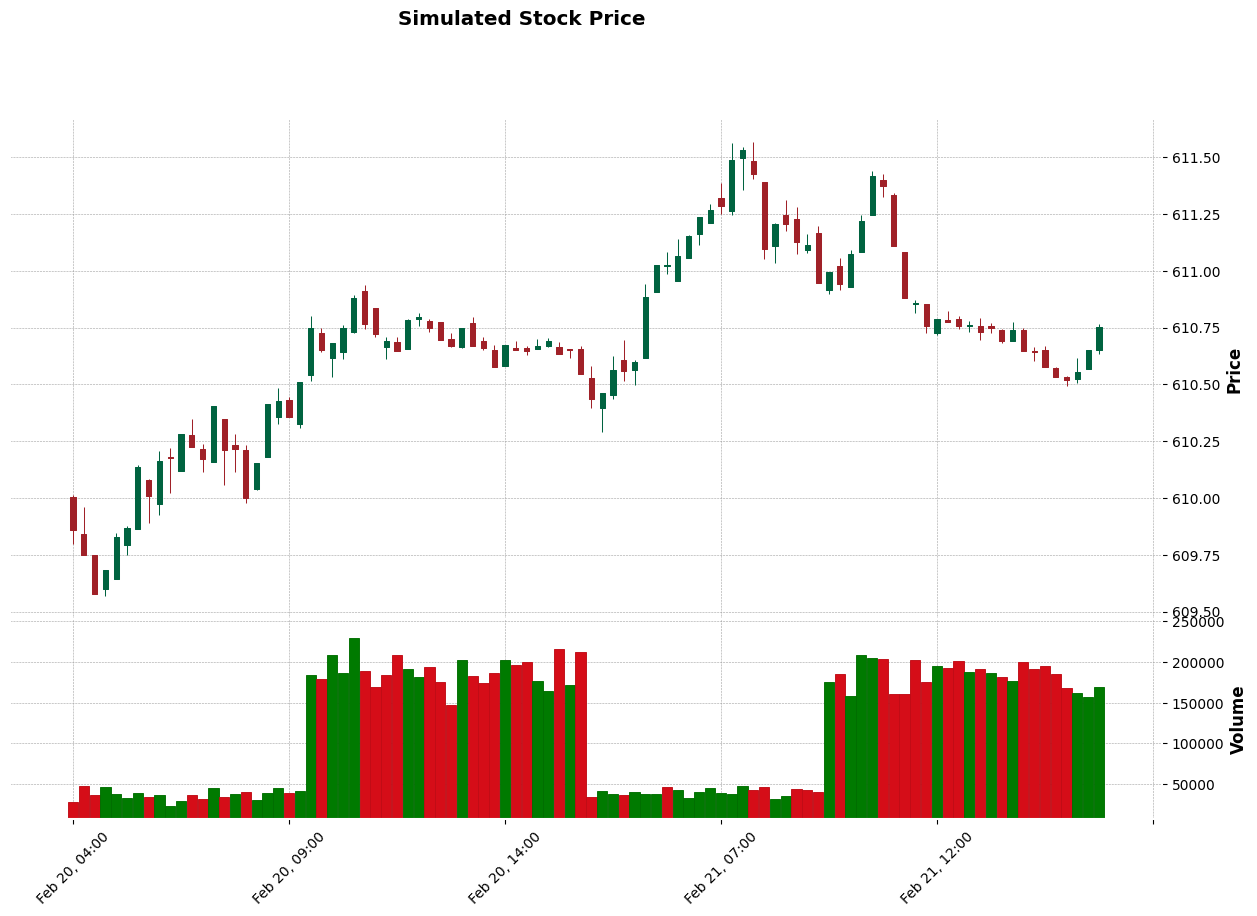

In [10]:
from generate_candlestick_df import generate_candlestick
import mplfinance as fplt

# Generate candlestick data
candlestick_data = generate_candlestick(simulated_data, intervalAmt) # change this to change the interval on the candlestick chart

# Prepare the data for mplfinance
candlestick_data.set_index('Timestamp', inplace=True)

# print(candlestick_data.head())

# Select the columns required for candlestick plot
candlestick_data = candlestick_data[['Open', 'High', 'Low', 'Close', 'Volume']]

# Plot the data as a candlestick chart with larger size
fplt.plot(
    candlestick_data,
    type='candle',
    style='charles',
    title="Simulated Stock Price",
    ylabel='Price',
    volume=True,
    figsize=(16, 10)  # Adjust the figure size here
)


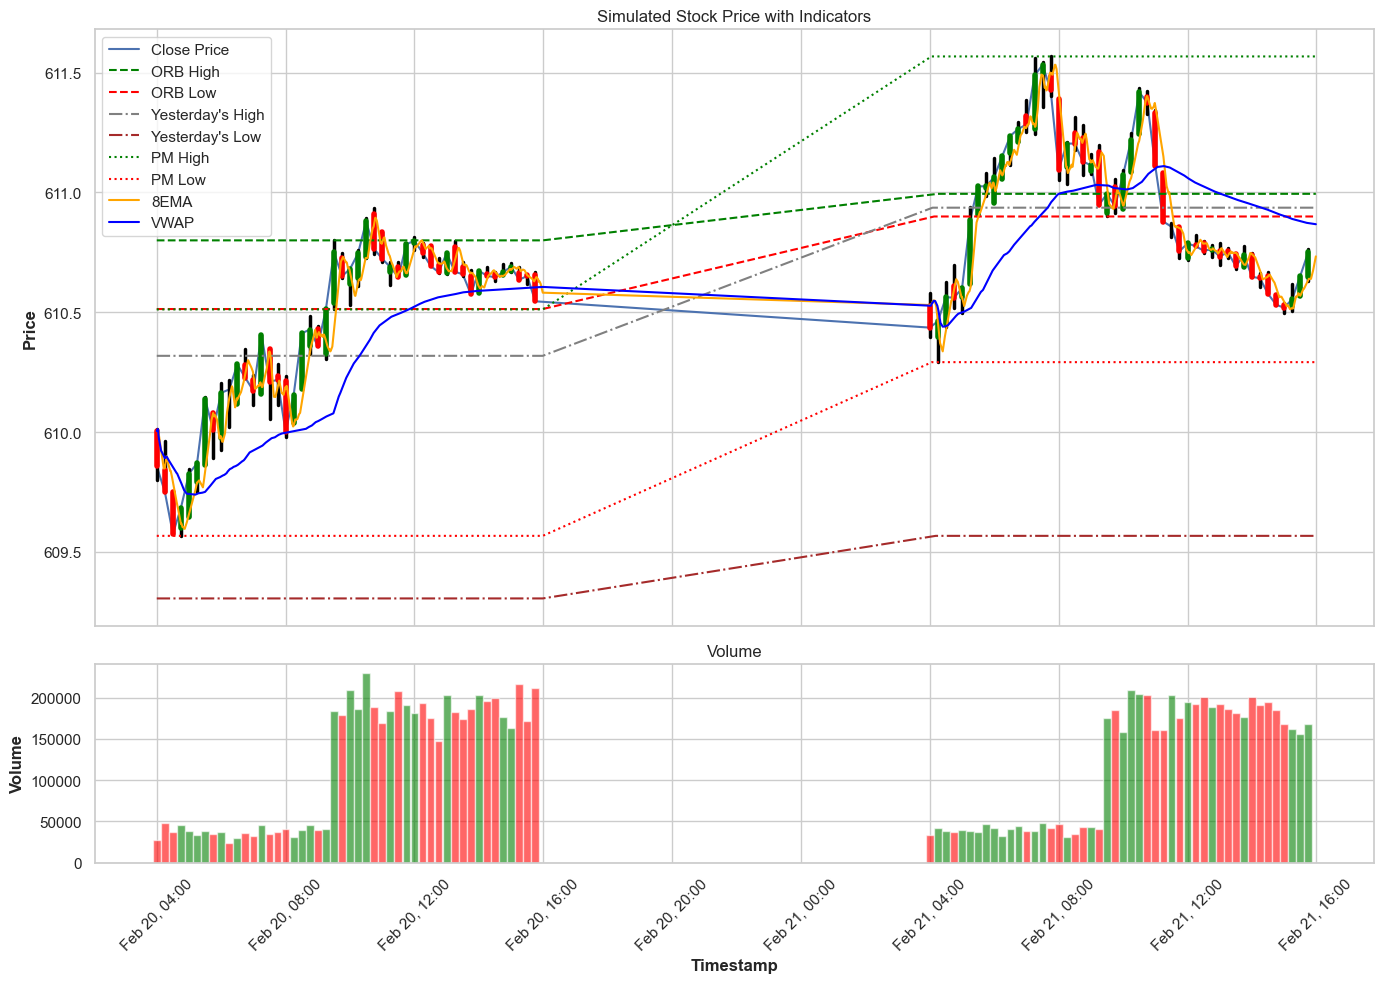

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_candlestick_with_indicators(candlestick_data, simulated_data, volume_ylim=None):
    # Set seaborn style
    sns.set(style="whitegrid")

    # Filter the simulated_data to include only timestamps between 04:00 and 16:00
    filtered_data = simulated_data[(simulated_data['Timestamp'].dt.time >= pd.to_datetime('04:00').time()) & 
                                   (simulated_data['Timestamp'].dt.time <= pd.to_datetime('16:00').time())]

    # Create a figure and axis for the candlestick chart
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

    # Plot the candlestick data
    sns.lineplot(data=candlestick_data, x=candlestick_data.index, y='Close', ax=ax1, label='Close Price')

    # Add vertical lines for open, high, low, and close prices
    for idx, row in candlestick_data.iterrows():
        ax1.plot([idx, idx], [row['Low'], row['High']], color='black', linewidth=2.5)  # Thicker lines
        ax1.plot([idx, idx], [row['Open'], row['Close']], color='green' if row['Close'] >= row['Open'] else 'red', linewidth=4)  # Thicker candlesticks

    # Plot the volume data as a histogram
    colors = ['green' if row['Close'] >= row['Open'] else 'red' for idx, row in candlestick_data.iterrows()]
    ax2.bar(candlestick_data.index, candlestick_data['Volume'], color=colors, alpha=0.6, width=0.01)

    # Plot the indicators
    ax1.plot(filtered_data['Timestamp'], filtered_data['ORB_High'], label='ORB High', linestyle='--', color='green')
    ax1.plot(filtered_data['Timestamp'], filtered_data['ORB_Low'], label='ORB Low', linestyle='--', color='red')
    ax1.plot(filtered_data['Timestamp'], filtered_data['Yest_High'], label="Yesterday's High", linestyle='-.', color='gray')
    ax1.plot(filtered_data['Timestamp'], filtered_data['Yest_Low'], label="Yesterday's Low", linestyle='-.', color='brown')
    ax1.plot(filtered_data['Timestamp'], filtered_data['PM_High'], label='PM High', linestyle=':', color='green')
    ax1.plot(filtered_data['Timestamp'], filtered_data['PM_Low'], label='PM Low', linestyle=':', color='red')
    ax1.plot(filtered_data['Timestamp'], filtered_data['8EMA'], label='8EMA', color='orange')
    ax1.plot(filtered_data['Timestamp'], filtered_data['VWAP'], label='VWAP', color='blue')

    # Set titles and labels
    ax1.set_title("Simulated Stock Price with Indicators")
    ax1.set_ylabel("Price")
    ax2.set_title("Volume")
    ax2.set_xlabel("Timestamp")
    ax2.set_ylabel("Volume")

    # Set y-axis limits for the volume histogram if provided
    if volume_ylim:
        ax2.set_ylim(volume_ylim)

    # Rotate x-axis labels for better readability
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %d, %H:%M'))
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

    # Add legend
    ax1.legend()

    # Adjust layout for better appearance
    plt.tight_layout()
    plt.show()

# Example usage
plot_candlestick_with_indicators(candlestick_data, simulated_data)


In [12]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

def plot_candlestick_with_indicators(candlestick_data, simulated_data):
    # Create a figure with a single subplot
    fig = make_subplots(rows=1, cols=1, shared_xaxes=True, 
                        vertical_spacing=0.1, 
                        subplot_titles=("Candlestick Plot",))

    # Add candlestick traces
    fig.add_trace(go.Candlestick(
        x=candlestick_data.index,
        open=candlestick_data['Open'],
        high=candlestick_data['High'],
        low=candlestick_data['Low'],
        close=candlestick_data['Close'],
        name='Candlestick',
        opacity=1
    ), row=1, col=1)

    # Add indicators to the candlestick plot
    fig.add_trace(go.Scatter(
        x=simulated_data['Timestamp'],
        y=simulated_data['ORB_High'],
        mode='lines',
        name='ORB High',
        line=dict(color='green', dash='dash')
    ), row=1, col=1)

    fig.add_trace(go.Scatter(
        x=simulated_data['Timestamp'],
        y=simulated_data['ORB_Low'],
        mode='lines',
        name='ORB Low',
        line=dict(color='red', dash='dash')
    ), row=1, col=1)

    fig.add_trace(go.Scatter(
        x=simulated_data['Timestamp'],
        y=simulated_data['Yest_High'],
        mode='lines',
        name="Yesterday's High",
        line=dict(color='gray', dash='dashdot')
    ), row=1, col=1)
    
    fig.add_trace(go.Scatter(
        x=simulated_data['Timestamp'],
        y=simulated_data['Yest_Low'],
        mode='lines',
        name="Yesterday's Low",
        line=dict(color='brown', dash='dashdot')
    ), row=1, col=1)

    fig.add_trace(go.Scatter(
        x=simulated_data['Timestamp'],
        y=simulated_data['PM_High'],
        mode='lines',
        name='PM High',
        line=dict(color='green', dash='dot')
    ), row=1, col=1)

    fig.add_trace(go.Scatter(
        x=simulated_data['Timestamp'],
        y=simulated_data['PM_Low'],
        mode='lines',
        name='PM Low',
        line=dict(color='red', dash='dot')
    ), row=1, col=1)

    fig.add_trace(go.Scatter(
        x=simulated_data['Timestamp'],
        y=simulated_data['8EMA'],
        mode='lines',
        name='8EMA',
        line=dict(color='orange')
    ), row=1, col=1)

    fig.add_trace(go.Scatter(
        x=simulated_data['Timestamp'],
        y=simulated_data['VWAP'],
        mode='lines',
        name='VWAP',
        line=dict(color='blue')
    ), row=1, col=1)

    # Add PM and Regular Market values
    fig.add_trace(go.Scatter(
        x=simulated_data[simulated_data['Session'] == 'PM']['Timestamp'],
        y=simulated_data[simulated_data['Session'] == 'PM']['Close'],
        mode='lines',
        name='Pre-Market Value',
        line=dict(color='black', dash='dot'),
        opacity=0.7
    ), row=1, col=1)
    
    fig.add_trace(go.Scatter(
        x=simulated_data[simulated_data['Session'] == 'Regular Market']['Timestamp'],
        y=simulated_data[simulated_data['Session'] == 'Regular Market']['Close'],
        mode='lines',
        name='Regular Market Value',
        line=dict(color='steelblue'),
        opacity=0.8
    ), row=1, col=1)

    # Update layout for better appearance
    fig.update_layout(
        title="Simulated Stock Price with Indicators",
        xaxis_title="Timestamp",
        yaxis_title="Price",
        legend_title="Legend",
        xaxis=dict(tickangle=45),
        template="seaborn",
        hovermode='x unified',
        height=800  # Make the graph taller
    )

    # Show the plot
    fig.show()

# Example usage
plot_candlestick_with_indicators(candlestick_data, simulated_data)

In [13]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

def plot_volume_histogram(candlestick_data):
    fig = make_subplots(rows=1, cols=1, subplot_titles=("Volume"))

    # Determine the color for each bar based on the candlestick data
    colors = ['green' if row['Close'] >= row['Open'] else 'red' for idx, row in candlestick_data.iterrows()]

    # Add volume as a bar chart
    fig.add_trace(go.Bar(
        x=candlestick_data.index,
        y=candlestick_data['Volume'],
        name='Volume',
        marker_color=colors,
        opacity=0.8
    ))

    # Update layout for better appearance
    fig.update_layout(
        title="Volume Histogram",
        xaxis_title="Timestamp",
        yaxis_title="Volume",
        legend_title="Legend",
        xaxis=dict(tickangle=45),
        template="seaborn",
        hovermode='x unified',
        height=400  # Adjust the height as needed
    )

    # Show the plot
    fig.show()

# Example usage
plot_volume_histogram(candlestick_data)

In [14]:
import plotly.graph_objects as go

def plot_candlestick_with_indicators(candlestick_data, simulated_data):
    # Create a figure
    fig = go.Figure()

    # Add candlestick traces
    fig.add_trace(go.Candlestick(
        x=candlestick_data.index,
        open=candlestick_data['Open'],
        high=candlestick_data['High'],
        low=candlestick_data['Low'],
        close=candlestick_data['Close'],
        name='Candlestick',
        opacity=1,
        hoverinfo='x+y+name'
    ))

    # Add indicators to the candlestick plot
    fig.add_trace(go.Scatter(
        x=simulated_data['Timestamp'],
        y=simulated_data['ORB_High'],
        mode='lines',
        name='ORB High',
        line=dict(color='green', dash='dash'),
        hoverinfo='x+y+name'
    ))

    fig.add_trace(go.Scatter(
        x=simulated_data['Timestamp'],
        y=simulated_data['ORB_Low'],
        mode='lines',
        name='ORB Low',
        line=dict(color='red', dash='dash'),
        hoverinfo='x+y+name'
    ))

    fig.add_trace(go.Scatter(
        x=simulated_data['Timestamp'],
        y=simulated_data['Yest_High'],
        mode='lines',
        name="Yesterday's High",
        line=dict(color='gray', dash='dashdot'),
        hoverinfo='x+y+name'
    ))

    fig.add_trace(go.Scatter(
        x=simulated_data['Timestamp'],
        y=simulated_data['Yest_Low'],
        mode='lines',
        name="Yesterday's Low",
        line=dict(color='brown', dash='dashdot'),
        hoverinfo='x+y+name'
    ))

    fig.add_trace(go.Scatter(
        x=simulated_data['Timestamp'],
        y=simulated_data['PM_High'],
        mode='lines',
        name='PM High',
        line=dict(color='green', dash='dot'),
        hoverinfo='x+y+name'
    ))

    fig.add_trace(go.Scatter(
        x=simulated_data['Timestamp'],
        y=simulated_data['PM_Low'],
        mode='lines',
        name='PM Low',
        line=dict(color='red', dash='dot'),
        hoverinfo='x+y+name'
    ))

    fig.add_trace(go.Scatter(
        x=simulated_data['Timestamp'],
        y=simulated_data['8EMA'],
        mode='lines',
        name='8EMA',
        line=dict(color='orange'),
        hoverinfo='x+y+name'
    ))

    fig.add_trace(go.Scatter(
        x=simulated_data['Timestamp'],
        y=simulated_data['VWAP'],
        mode='lines',
        name='VWAP',
        line=dict(color='blue'),
        hoverinfo='x+y+name'
    ))

    # Add PM and Regular Market values
    fig.add_trace(go.Scatter(
        x=simulated_data[simulated_data['Session'] == 'PM']['Timestamp'],
        y=simulated_data[simulated_data['Session'] == 'PM']['Close'],
        mode='lines',
        name='PM',
        line=dict(color='black', dash='dot'),
        opacity=0.7,
        hoverinfo='x+y+name'
    ))

    fig.add_trace(go.Scatter(
        x=simulated_data[simulated_data['Session'] == 'Regular Market']['Timestamp'],
        y=simulated_data[simulated_data['Session'] == 'Regular Market']['Close'],
        mode='lines',
        name='Regular Market',
        line=dict(color='steelblue'),
        opacity=0.8,
        hoverinfo='x+y+name'
    ))

    # Update layout for better appearance
    fig.update_layout(
        title="Simulated Stock Price with Indicators",
        xaxis_title="Timestamp",
        yaxis_title="Price",
        legend_title="Legend",
        xaxis=dict(tickangle=45),
        template="seaborn",
        hovermode='x unified',
        height=800  # Make the graph taller
    )

    # Show the plot
    fig.show()

# Example usage
plot_candlestick_with_indicators(candlestick_data, simulated_data)
